# Семантическая сегментация 
### Задача 
Обучить модель семантической сегментации (человек-vs-фон) на подмножестве датасета MS COCO
<br>Библиотеки: [Python, Tensorflow]
### Решение

In [1]:
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

In [2]:
%%capture
!pip install scikit-video==1.1.11
import skvideo.io
from shutil import copy, copytree, rmtree
from collections import defaultdict

## Загрузка и распаковка датасета KTH

In [3]:
%%capture
%%time
if not os.path.isdir('walking'):
    !wget http://www.nada.kth.se/cvap/actions/walking.zip
    !unzip walking.zip -d walking
    !rm walking.zip
if not os.path.isdir('jogging'):
    !wget http://www.nada.kth.se/cvap/actions/jogging.zip
    !unzip jogging.zip -d jogging
    !rm jogging.zip
if not os.path.isdir('running'):
    !wget http://www.nada.kth.se/cvap/actions/running.zip
    !unzip running.zip -d running
    !rm running.zip
if not os.path.isdir('boxing'):
    !wget http://www.nada.kth.se/cvap/actions/boxing.zip
    !unzip boxing.zip -d boxing
    !rm boxing.zip
if not os.path.isdir('handwaving'):
    !wget http://www.nada.kth.se/cvap/actions/handwaving.zip
    !unzip handwaving.zip -d handwaving
    !rm handwaving.zip
if not os.path.isdir('handclapping'):
    !wget http://www.nada.kth.se/cvap/actions/handclapping.zip
    !unzip handclapping.zip -d handclapping
    !rm handclapping.zip

## Подготовка датасета для классификации

In [4]:
classes = [
    'walking',
    'jogging',
    'running',
    'boxing',
    'handwaving',
    'handclapping',
]

В качестве тестовой выборки сделаем все видео людей под номерами 20, 21, 22, 23, 24. То есть примерно 20% от всей выборки.

In [5]:
train_samples = []
test_samples = []

for i, cls in enumerate(classes):
    for path in os.listdir(cls):
        if path.startswith('person2'):
            test_samples.append((os.path.join(cls, path), i))
        else:
            train_samples.append((os.path.join(cls, path), i))

np.random.seed(21)
np.random.shuffle(train_samples)
np.random.shuffle(test_samples)

In [6]:
train_samples[:3]

[('running/person08_running_d3_uncomp.avi', 2),
 ('jogging/person15_jogging_d4_uncomp.avi', 1),
 ('running/person19_running_d1_uncomp.avi', 2)]

In [8]:
test_samples[-3:]

[('handwaving/person21_handwaving_d3_uncomp.avi', 4),
 ('walking/person22_walking_d3_uncomp.avi', 0),
 ('running/person24_running_d3_uncomp.avi', 2)]

In [10]:
train_paths, train_labels = map(np.array, list(zip(*train_samples)))
train_labels = tf.one_hot(train_labels, len(classes))

test_paths, test_labels = map(np.array, list(zip(*test_samples)))
test_labels = tf.one_hot(test_labels, len(classes))

In [11]:
def read_prepare(fpath):
    videodata = tf.py_function(
        lambda x: skvideo.io.vread(x.numpy().decode()), 
        [fpath], 
        tf.uint8)
    videodata = tf.cast(videodata, tf.float32) / 255.
    motion = tf.math.reduce_mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)
    return motion

Создаём пайплайны данных

In [12]:
BATCH_SIZE = 1

train_x = tf.data.Dataset.from_tensor_slices(train_paths)
train_x = train_x.map(read_prepare)
train_y = tf.data.Dataset.from_tensor_slices(train_labels)
train_ds = tf.data.Dataset.zip((train_x, train_y))
train_ds = train_ds.batch(BATCH_SIZE)

test_x = tf.data.Dataset.from_tensor_slices(test_paths)
test_x = test_x.map(read_prepare)
test_y = tf.data.Dataset.from_tensor_slices(test_labels)
test_ds = tf.data.Dataset.zip((test_x, test_y))
test_ds = test_ds.batch(BATCH_SIZE)

## Создание модели

In [13]:
def create_model():
    inp = tf.keras.Input((None, 120, 160, 1))

    x = tf.keras.layers.Conv3D(32, (5, 5, 5), (1, 2, 2), padding='same', activation='relu')(inp)
    x = tf.keras.layers.MaxPool3D((1, 2, 2), padding='same')(x)

    x = tf.keras.layers.Conv3D(64, (5, 5, 5), (1, 2, 2), padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPool3D((1, 2, 2), padding='same')(x)

    x = tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 2, 2), padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPool3D((1, 2, 2), padding='same')(x)

    x = tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 1, 1), padding='same')(x)
    x = tf.keras.layers.GlobalAveragePooling3D()(x)

    x = tf.keras.layers.Dense(64, activation='relu')(x)

    out = tf.keras.layers.Dense(6, activation='softmax')(x)
    return tf.keras.Model(inputs=inp, outputs=out)

In [14]:
model = create_model()

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

## Обучение

In [15]:
NUM_EPOCHS = 10

history = model.fit(
    train_ds,
    epochs=NUM_EPOCHS,
    validation_data=test_ds)

Epoch 1/10
455/455 [==============================] - 540s 1s/step - loss: 1.5423 - accuracy: 0.3943 - val_loss: 0.6846 - val_accuracy: 0.7268
Epoch 2/10
455/455 [==============================] - 292s 643ms/step - loss: 0.6891 - accuracy: 0.7188 - val_loss: 0.4541 - val_accuracy: 0.8132
Epoch 3/10
455/455 [==============================] - 293s 645ms/step - loss: 0.4354 - accuracy: 0.8034 - val_loss: 0.3678 - val_accuracy: 0.8494
Epoch 4/10
455/455 [==============================] - 294s 646ms/step - loss: 0.4136 - accuracy: 0.8135 - val_loss: 0.3473 - val_accuracy: 0.8594
Epoch 5/10
455/455 [==============================] - 295s 648ms/step - loss: 0.4489 - accuracy: 0.7993 - val_loss: 0.3515 - val_accuracy: 0.8349
Epoch 6/10
455/455 [==============================] - 290s 638ms/step - loss: 0.4105 - accuracy: 0.8182 - val_loss: 0.3391 - val_accuracy: 0.8683
Epoch 7/10
455/455 [==============================] - 286s 628ms/step - loss: 0.4194 - accuracy: 0.8117 - val_loss: 0.3478 - va

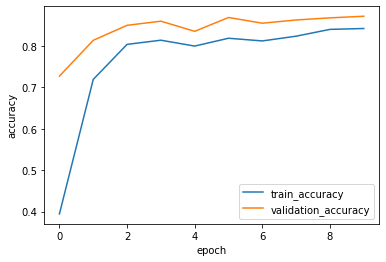

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
plt.show()

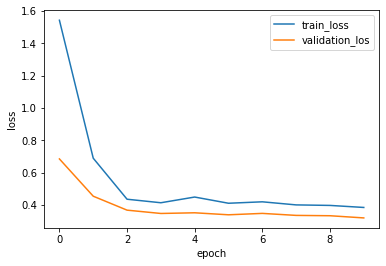

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'validation_los'], loc='best')
plt.show()

## Тестирование обученной модели

In [18]:
def inference(sample):
    video, label = sample
    
    pred = model(video)
    pred = np.argmax(pred.numpy())
    label = np.argmax(label.numpy())

    print(f'true: {classes[label]}')
    print(f'pred: {classes[pred]}')

    fig = plt.figure(figsize=(20, 10))
    
    for i in range(50, 100, 7):
        ax = fig.add_subplot(1, 8, j+1)
        ax.imshow(video[0, i, :, :, 0])
        plt.xticks([]), plt.yticks([])
    plt.show()

In [19]:
samples = list(test_ds.take(3))

true: handwaving
pred: handwaving


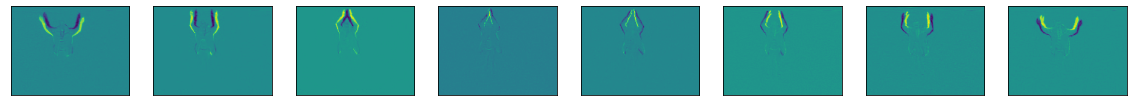

true: walking
pred: walking


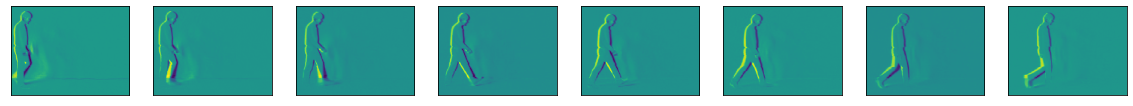

true: walking
pred: jogging


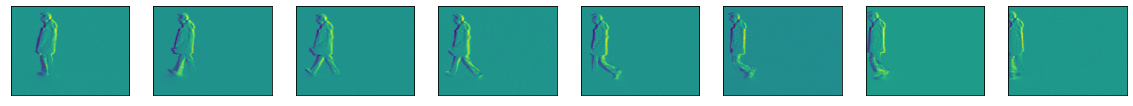

In [20]:
for sample in list(test_ds.take(3)):
    video, label = sample
    
    pred = model(video)
    pred = np.argmax(pred.numpy())
    label = np.argmax(label.numpy())

    print(f'true: {classes[label]}')
    print(f'pred: {classes[pred]}')

    fig = plt.figure(figsize=(20, 10))
    
    for i in range(50, 100, 7):
        ax = fig.add_subplot(1, 8, j+1)
        ax.imshow(video[0, i, :, :, 0])
        plt.xticks([]), plt.yticks([])
    plt.show()